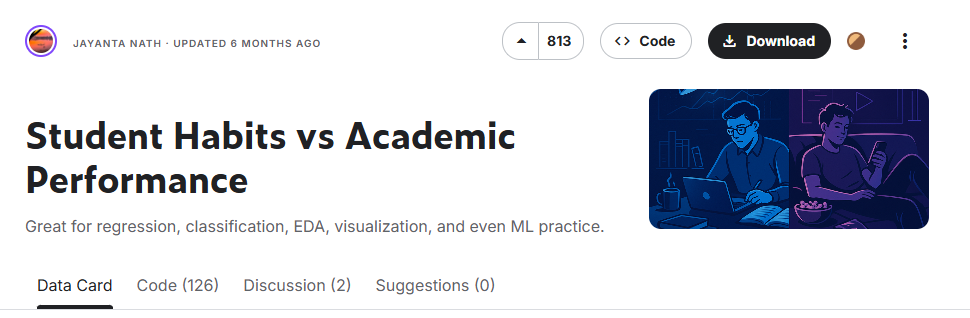
<br>학생들의 생활 습관이 학업 성적에 미치는 영향 분석

# Data Load

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import shap

import warnings
warnings.filterwarnings(action='ignore')

import sklearn
from sklearn.ensemble import StackingRegressor

#----- 수치형 변환
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

#----- PCA(차원축소:주성분분석)
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split

#----- 회귀모델(+통계)
# from sklearn.linear_model import LogisticRegression XXXX 분류
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
#----- 외부 회귀모델(+별도설치)
from xgboost  import XGBRegressor
from lightgbm import LGBMRegressor

# Google -- 
#----- 정규화/스케일러
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#----- 교차검증 : StratifiedKFold(y를 고르게 폴드에 분재한다는것은 회귀에서 없다)
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, GridSearchCV
                                       
#----- 회귀 평가 매트릭스
from sklearn.metrics import mean_squared_error,root_mean_squared_error,r2_score

# matplotlib 차트 스타일을 seaborn 스타일로 설정
sns.set()

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
# from IPython.core.display import display, HTML
from IPython.display import display, HTML

display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

| 컬럼명 (Column Name) | 내용 (Description) |
| :--- | :--- |
| `student_id` | 학생 ID (식별자) |
| `age` | 나이 |
| `gender` | 성별 |
| `study_hours_per_day` | 하루(일일) 공부 시간 |
| `social_media_hours` | 하루(일일) 소셜 미디어 사용 시간 |
| `netflix_hours` | 하루(일일) 넷플릭스 시청 시간 |
| `part_time_job` | 아르바이트 유무 (Yes/No) |
| `attendance_percentage` | 수업 출석률 (%) |
| `sleep_hours` | 하루(일일) 평균 수면 시간 |
| `diet_quality` | 식단의 질 (e.g., Good, Average, Poor) |
| `exercise_frequency` | 운동 빈도 (e.g., Weekly, Monthly, Rarely) |
| `parental_education_level` | 부모님의 최종 학력 수준 |
| `internet_quality` | 인터넷 품질 (e.g., Good, Poor) |
| `mental_health_rating` | 본인이 평가한 정신 건강 점수 (e.g., 1~5) |
| `extracurricular_participation` | 교과 외 활동(동아리 등) 참여 여부 |
| `exam_score` | 시험 점수 (예측 대상 타겟) |

In [2]:
df = pd.read_csv("datas/student_habits_performance.csv")
df.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


# 1차 전처리

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   student_id                     1000 non-null   object 
 1   age                            1000 non-null   int64  
 2   gender                         1000 non-null   object 
 3   study_hours_per_day            1000 non-null   float64
 4   social_media_hours             1000 non-null   float64
 5   netflix_hours                  1000 non-null   float64
 6   part_time_job                  1000 non-null   object 
 7   attendance_percentage          1000 non-null   float64
 8   sleep_hours                    1000 non-null   float64
 9   diet_quality                   1000 non-null   object 
 10  exercise_frequency             1000 non-null   int64  
 11  parental_education_level       909 non-null    object 
 12  internet_quality               1000 non-null   ob

In [4]:
df.shape

(1000, 16)

## 결측치 처리

In [5]:
df.isnull().sum()

student_id                        0
age                               0
gender                            0
study_hours_per_day               0
social_media_hours                0
netflix_hours                     0
part_time_job                     0
attendance_percentage             0
sleep_hours                       0
diet_quality                      0
exercise_frequency                0
parental_education_level         91
internet_quality                  0
mental_health_rating              0
extracurricular_participation     0
exam_score                        0
dtype: int64

In [ ]:
# 결측치는 새로운 카테고리로 정의
df['parental_education_level'] = df['parental_education_level'].fillna('Unknown')

In [7]:
df['parental_education_level'].value_counts()

parental_education_level
High School    392
Bachelor       350
Master         167
Unknown         91
Name: count, dtype: int64

## 인코딩

In [8]:
lists = ['gender', 'part_time_job', 'diet_quality', 'parental_education_level', 'internet_quality', 'extracurricular_participation']

In [9]:
df[lists].nunique()

gender                           3
part_time_job                    2
diet_quality                     3
parental_education_level         4
internet_quality                 3
extracurricular_participation    2
dtype: int64

In [10]:
for col in lists:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [11]:
df = df.drop('student_id', axis=1)

# EDA

### 데이터 분포도

<Figure size 1200x1000 with 0 Axes>

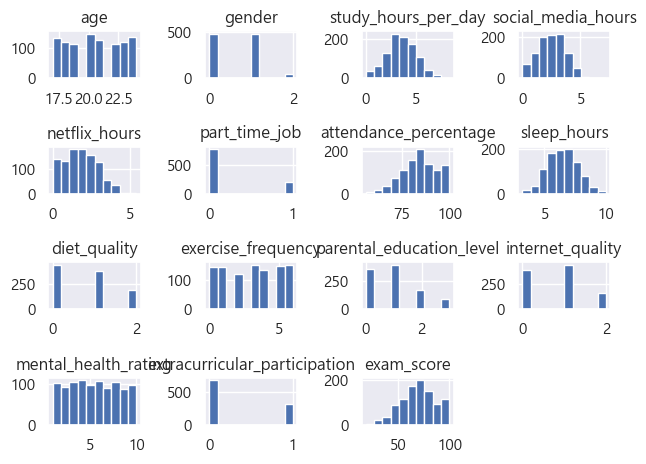

In [12]:
plt.figure(figsize=(12, 10))
df.hist()
plt.tight_layout()
plt.show()

### 왜도
* -0.5 ~ +0.5	거의 대칭 → 정규분포 유사 (정상 범위)
* -1 ~ -0.5 or 0.5 ~ 1	약간 비대칭 → 크게 문제 없음
* < -1 or > 1	심한 비대칭 → 비정상 분포 가능성 높음

In [13]:
X = df.drop('exam_score', axis=1)
y = df['exam_score']

In [14]:
from scipy.stats import skew,  kurtosis
s = pd.Series( skew(X) , index=X.columns)
s

age                              0.008424
gender                           0.424538
study_hours_per_day              0.054172
social_media_hours               0.119625
netflix_hours                    0.236799
part_time_job                    1.387461
attendance_percentage           -0.237454
sleep_hours                      0.091347
diet_quality                     0.446180
exercise_frequency              -0.031875
parental_education_level         0.662269
internet_quality                 0.358307
mental_health_rating             0.037754
extracurricular_participation    0.781620
dtype: float64

### 첨도
* Kurtosis 값 (pandas 기준) : 2 ~ 4 정상범위

In [ ]:
# 대부분 음수값이라 정규분포보다 더 평평한 형태를 가지고 있음
s = pd.Series( kurtosis(X) , index=X.columns)
s  

age                             -1.218901
gender                          -0.749900
study_hours_per_day             -0.061368
social_media_hours              -0.099606
netflix_hours                   -0.436691
part_time_job                   -0.074952
attendance_percentage           -0.394754
sleep_hours                     -0.219233
diet_quality                    -1.099234
exercise_frequency              -1.276146
parental_education_level        -0.455180
internet_quality                -0.968604
mental_health_rating            -1.188661
extracurricular_participation   -1.389070
dtype: float64

### 상관관계 확인
- 공부시간과 타겟값만 상관관계 높음
- 다중 공선 문제 없음
- 모델 학습 시 안정적이고 과적합 위험 낮음

<Axes: >

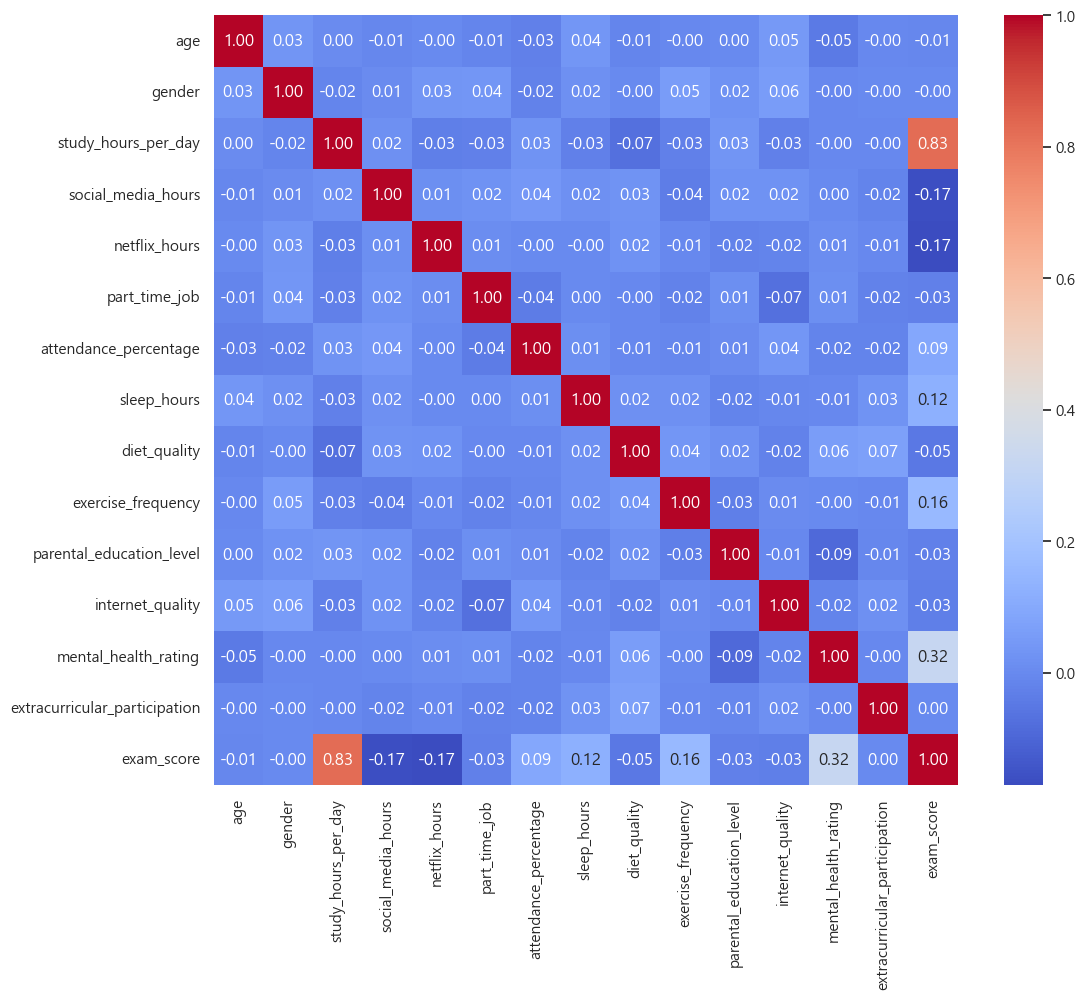

In [16]:
corr = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')

# 1차 점수

In [17]:
X80, X20, y80, y20 = train_test_split(X, y, test_size = 0.2, random_state=4444)

 9.8086  DecisionTreeRegressor   


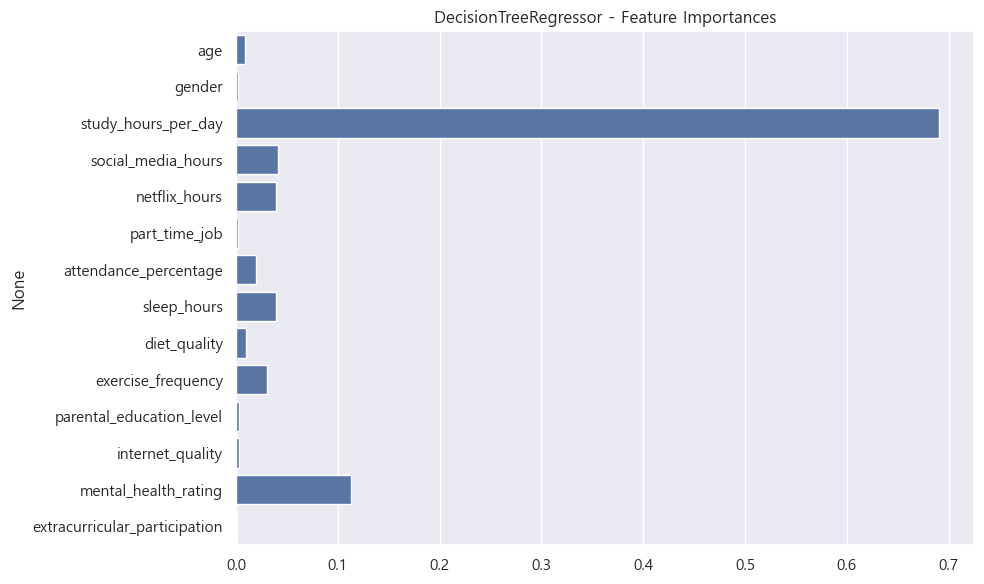

 6.6005  RandomForestRegressor   


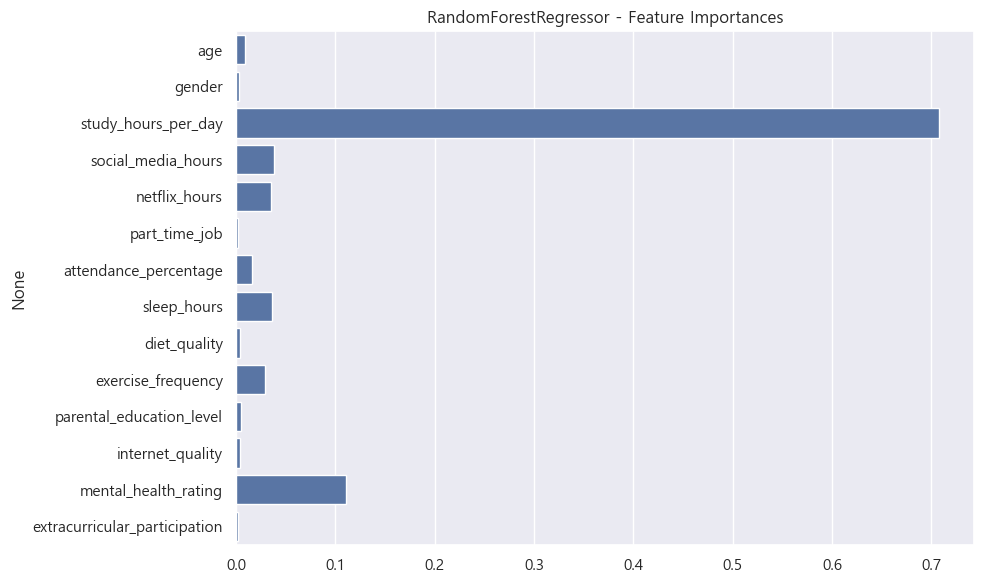

 16.0251  SVR   
--- SVR는 coef_ / feature_importances_ 속성을 제공하지 않습니다. ---
 5.6584  Ridge   


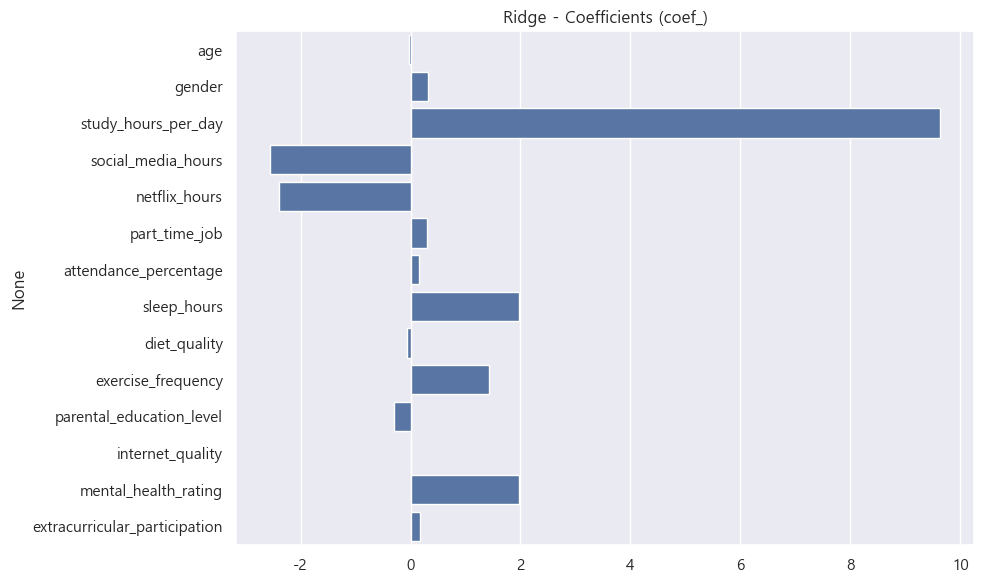

 5.8281  Lasso   


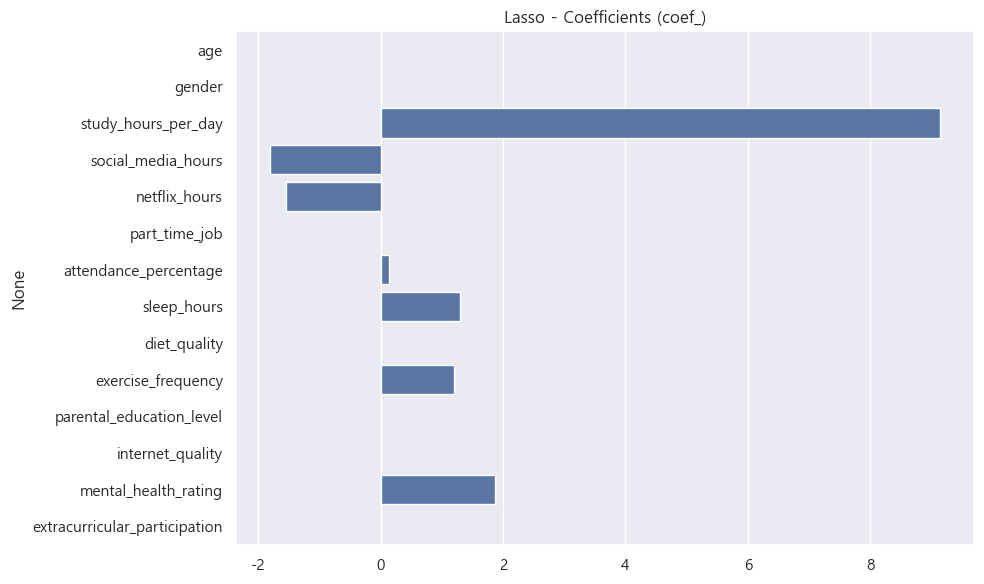

 6.4347  ElasticNet   


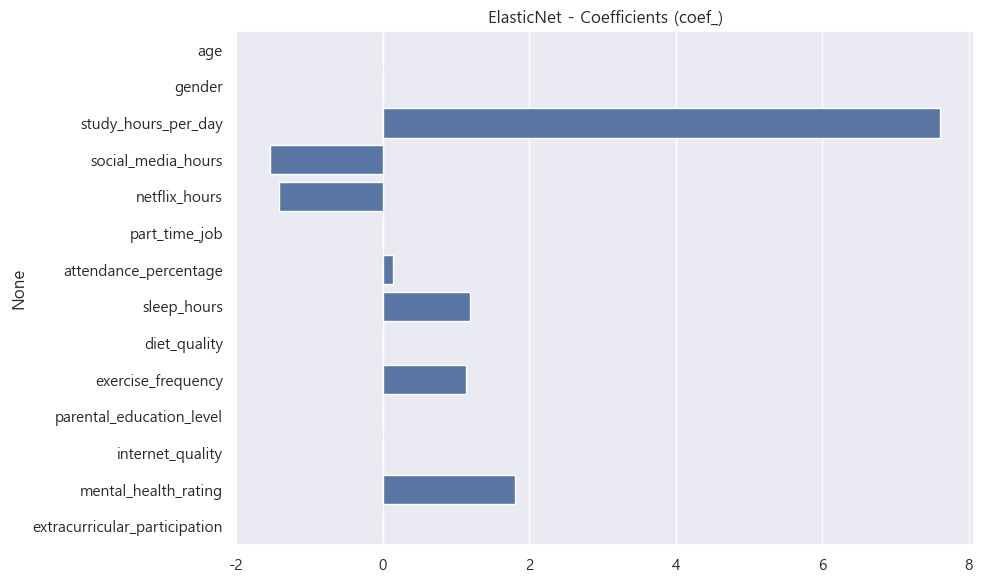

 6.5722  XGBRegressor   


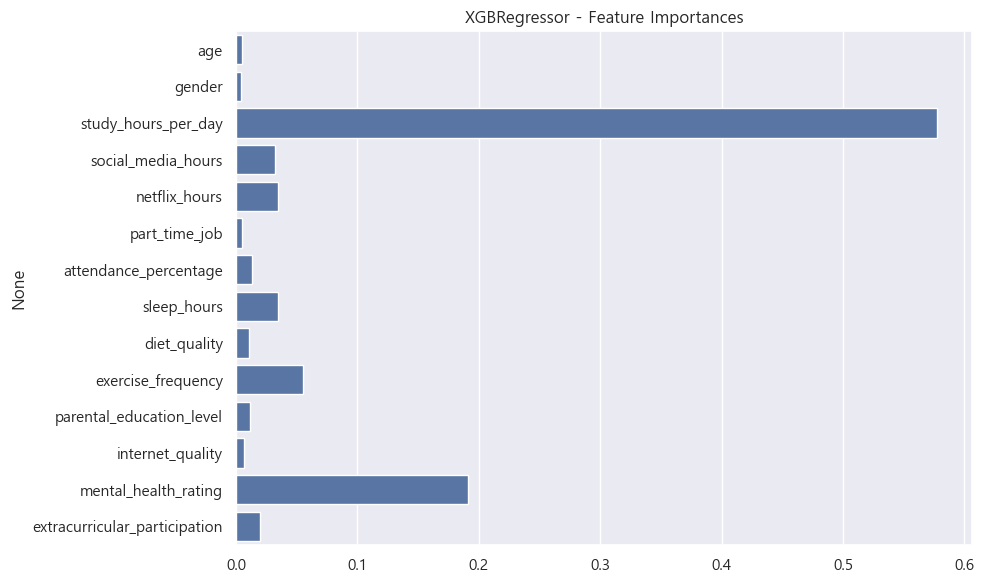

 6.3283  LGBMRegressor   


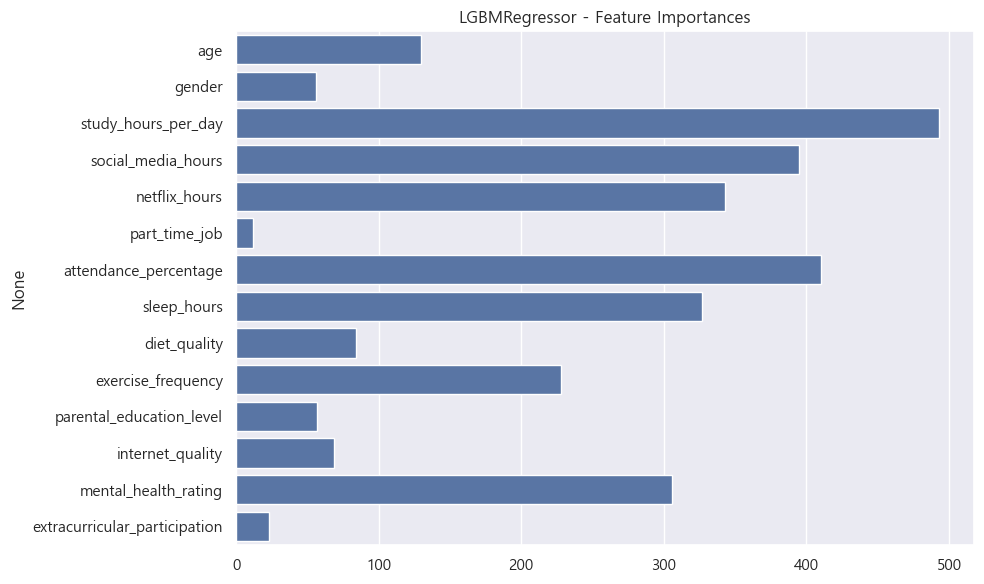

In [18]:
model_list = [  DecisionTreeRegressor(random_state=8989), 
                RandomForestRegressor(random_state=8989),
                SVR(),
                Ridge(random_state=8989),
                Lasso(random_state=8989),
                ElasticNet(random_state=8989),
                XGBRegressor(), LGBMRegressor(verbosity=-1)
             ] 
for model in model_list:
    model.fit(X80, y80)
    pred = model.predict(X20)
    mean_score = root_mean_squared_error(y20, pred)
    print( f" {mean_score:.4f}  {model.__class__.__name__}   " )
    feature_names = X80.columns
    # 2. 모델별 피처 중요도(또는 계수) 추출
    if hasattr(model, 'coef_'):
        # 선형 모델 (Ridge, Lasso, ElasticNet)
        importances = model.coef_
        title = f"{model.__class__.__name__} - Coefficients (coef_)"
        
    elif hasattr(model, 'feature_importances_'):
        # 트리 기반 모델 (DecisionTree, RandomForest, XGB, LGBM)
        importances = model.feature_importances_
        title = f"{model.__class__.__name__} - Feature Importances"
        
    else:
        # SVR(커널=rbf) 등은 해당 속성이 없음
        print(f"--- {model.__class__.__name__}는 coef_ / feature_importances_ 속성을 제공하지 않습니다. ---")
        continue # 다음 모델로 넘어감

    # 3. 바 차트(Bar chart) 그리기
    plt.figure(figsize=(10, 6)) # 매번 새 도화지를 만듦
    sns.barplot(x=importances, y=feature_names)
    plt.title(title)
    plt.tight_layout()
    plt.show() # 각 차트를 바로 보여줌

- 선형 모델 > 비선형(트리) 모델 (데이터가 선형적이다)
- 릿지 > 라쏘 (핵심 변수 + 약한 변수들의 조합이 가장 좋음)
<pre>
 9.8086  DecisionTreeRegressor   
 6.6005  RandomForestRegressor   
 16.0251  SVR   
 5.6584  Ridge   
 5.8281  Lasso   
 6.4347  ElasticNet   
 6.5722  XGBRegressor   
 6.3283  LGBMRegressor   


# 2차 전처리

## 원핫 인코딩 처리
- 오히려 점수 더 안좋아짐 (SVR만 조금 좋아짐)
- 데이터 행(1000개) 대비 피처가 너무 많아져서 성능이 나빠짐
    - '진짜 패턴'이 아닌 '우연한 노이즈'까지 과하게 학습

In [19]:
cat_col = ['gender', 'part_time_job', 'diet_quality', 'exercise_frequency', 
           'parental_education_level', 'internet_quality', 'extracurricular_participation', 'mental_health_rating']

X_one = pd.get_dummies(X, 
                             columns=cat_col, 
                             drop_first=True)

In [20]:
X80, X20, y80, y20 = train_test_split(X_one, y, test_size=0.2, random_state=4444)

model_list = [  DecisionTreeRegressor(random_state=8989), 
                RandomForestRegressor(random_state=8989),
                SVR(),
                Ridge(random_state=8989),
                Lasso(random_state=8989),
                ElasticNet(random_state=8989),
                XGBRegressor(), LGBMRegressor(verbosity=-1)
             ] 
for model in model_list:
    model.fit(X80, y80)
    pred = model.predict(X20)
    mean_score = root_mean_squared_error(y20, pred)
    print( f" {mean_score:.4f}  {model.__class__.__name__}   " )

 10.8012  DecisionTreeRegressor   
 7.4339  RandomForestRegressor   
 16.2281  SVR   
 5.7376  Ridge   
 7.9941  Lasso   
 8.4535  ElasticNet   
 7.2352  XGBRegressor   
 6.6203  LGBMRegressor   


<pre>
 9.7866  DecisionTreeRegressor   
 6.5577  RandomForestRegressor   
 16.0220  SVR   
 5.6430  Ridge   
 5.8281  Lasso   
 6.4347  ElasticNet   
 6.6833  XGBRegressor   
 6.4272  LGBMRegressor 

## 로그변환 & 스케일링
- StandardScaler 선택 이유
    - 첨도 값 모두 음수 == 정규분포보다 더 평평 & 꼬리가 얇다

### 범주형이 아닌 컬럼만 추출

In [21]:
num_col = [col for col in X.columns if col not in cat_col]

### 범주형 데이터 제외 로그화

In [22]:
# df_log = df.copy()
# df_log[num_col] = np.log1p(df_log[num_col])
# df_log.head()

In [23]:
# plt.figure(figsize=(12, 10))
# df_log.hist()
# plt.tight_layout()
# plt.show()

In [24]:
X80, X20, y80, y20 = train_test_split(X, y, test_size=0.2, random_state=4444)

### 범주형 제외 스케일링

In [25]:
# X = df_log.drop('exam_score', axis = 1)
# y = df_log['exam_score']

# X80, X20, y80, y20 = train_test_split(X, y, test_size=0.2, random_state=4444)
scaler = StandardScaler()

X80_scal = pd.DataFrame(
    scaler.fit_transform(X80[num_col]),
    columns=num_col,  # 원래 컬럼명 복원
    index=X80.index       # 원래 인덱스 복원
)

X20_scal = pd.DataFrame(
    scaler.transform(X20[num_col]),
    columns=num_col,  # 원래 컬럼명 복원
    index=X20.index       # 원래 인덱스 복원
)

# 4️⃣ 범주형 컬럼과 합치기
X80_final = pd.concat([X80_scal, X80[cat_col]], axis=1)
X20_final = pd.concat([X20_scal, X20[cat_col]], axis=1)

# 5️⃣ 컬럼 순서를 원본 X와 동일하게 맞추기
X80_final = X80_final[X.columns]
X20_final = X20_final[X.columns]

<Figure size 1200x1000 with 0 Axes>

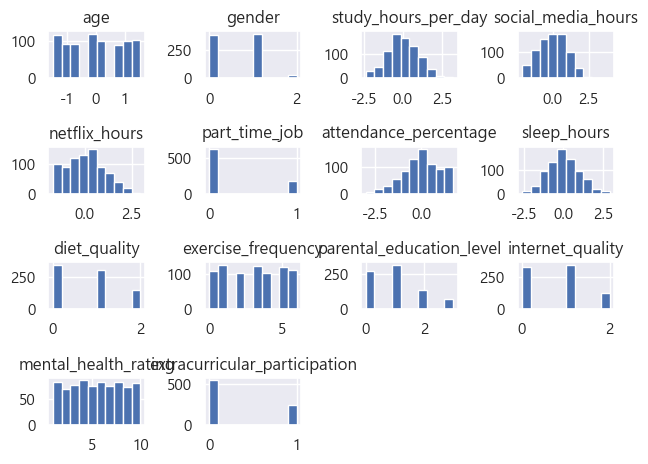

In [26]:
plt.figure(figsize=(12, 10))
X80_final.hist()
plt.tight_layout()
plt.show()

In [27]:
model_list = [  DecisionTreeRegressor(random_state=8989), 
                RandomForestRegressor(random_state=8989),
                SVR(),
                Ridge(random_state=8989),
                Lasso(random_state=8989),
                ElasticNet(random_state=8989),
                XGBRegressor(random_state=8989), 
                LGBMRegressor(random_state=8989, verbosity=-1)
             ] 
for model in model_list:
    model.fit(X80_final, y80)
    pred = model.predict(X20_final)
    mean_score = root_mean_squared_error(y20, pred)
    print( f" {mean_score:.4f}  {model.__class__.__name__}   " )

 9.6914  DecisionTreeRegressor   
 6.5869  RandomForestRegressor   
 8.2253  SVR   
 5.6575  Ridge   
 6.0228  Lasso   
 7.6309  ElasticNet   
 6.5722  XGBRegressor   
 6.3132  LGBMRegressor   


- SVR 모델은 거리기반 모델이기 때문에 단위차이가 크면 거리 계산이 왜곡 됨 (스케일링 필수)
- 로그변환은 패턴을 단순화 시켜서 점수가 더 떨어짐

| 전처리 방식 | DecisionTree | RandomForest | SVR | Ridge | Lasso | ElasticNet | XGB | LGBM |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| 1차 점수 (원본) | 9.7866 | 6.5577 | 16.0220 | 5.6430 | 5.8281 | 6.4347 | 6.6833 | 6.4272 |
| 원-핫 인코딩 | 10.8012 | 7.4339 | 16.2281 | 5.7376 | 7.9941 | 8.4535 | 7.2352 | 6.6203 |
| 스케일링 | 9.6897 | 6.5456 | 8.3918 | **5.6422** | 6.0228 | 7.6309 | 6.6833 | 6.4029 |
| 로그 & 스케일링 | 9.8578 | 6.5583 | 9.0187 | 6.0900 | 6.5964 | 8.2326 | 6.6833 | 6.4306 |

 9.6914  DecisionTreeRegressor   


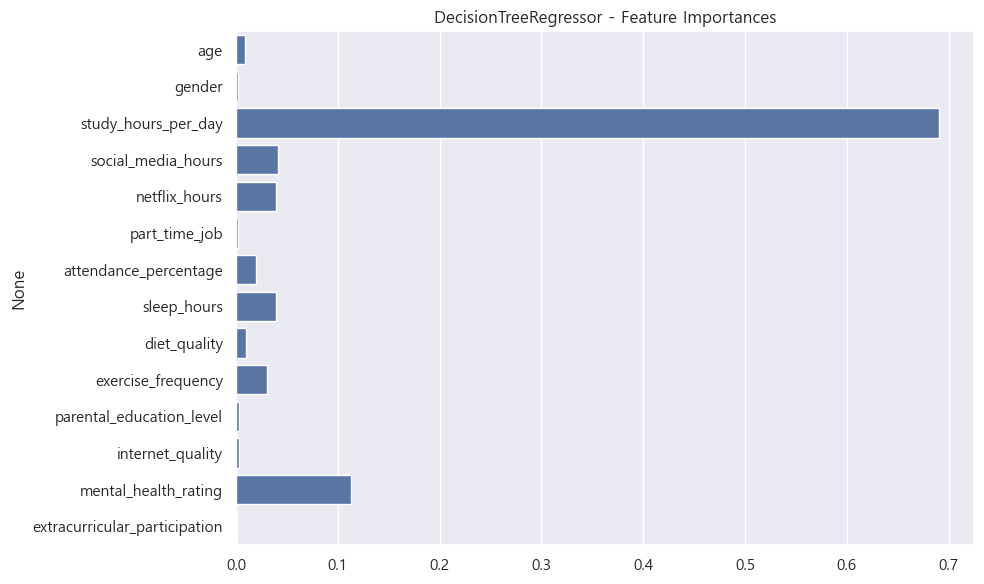

 6.5869  RandomForestRegressor   


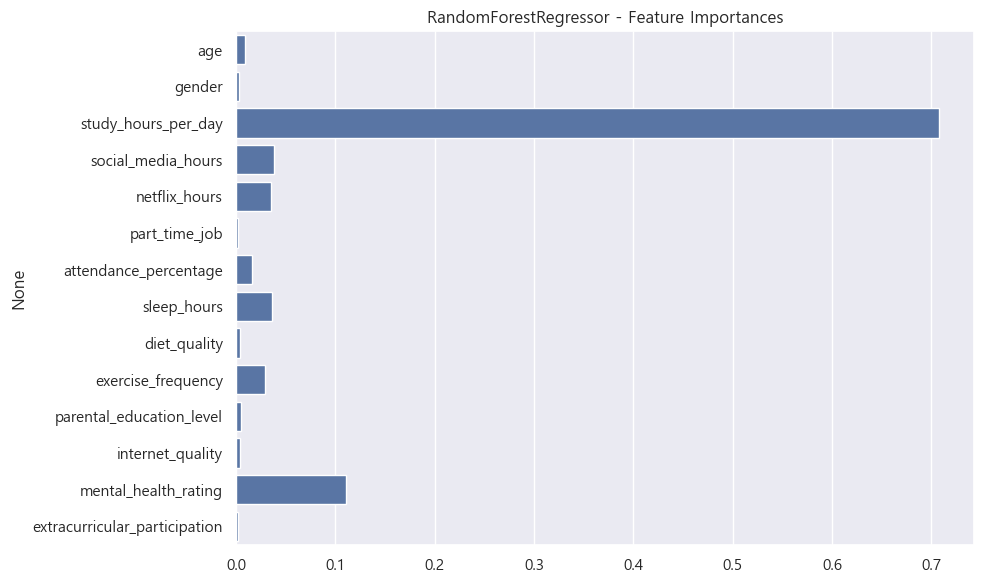

 8.2253  SVR   
--- SVR는 coef_ / feature_importances_ 속성을 제공하지 않습니다. ---
 5.6575  Ridge   


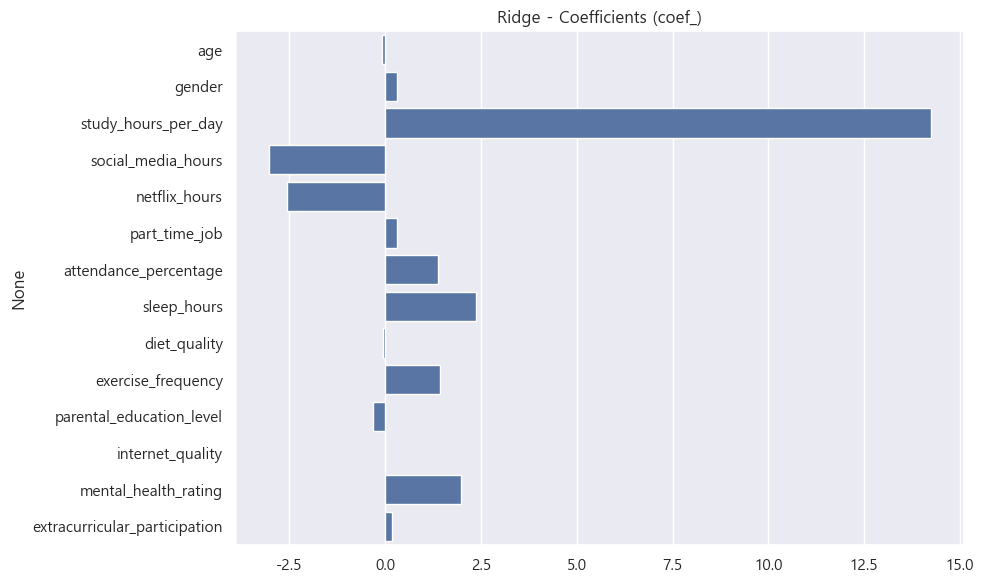

 6.0228  Lasso   


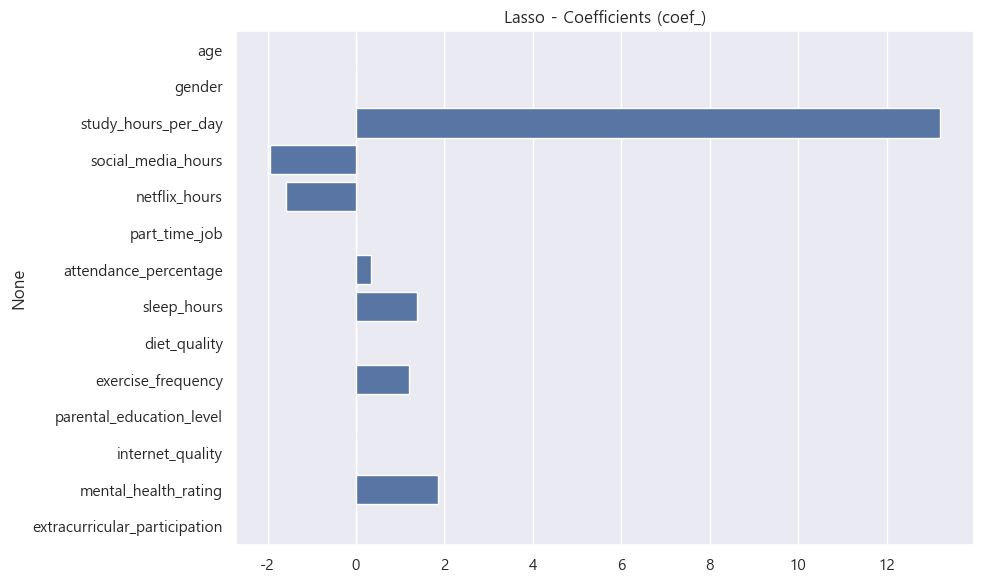

 7.6309  ElasticNet   


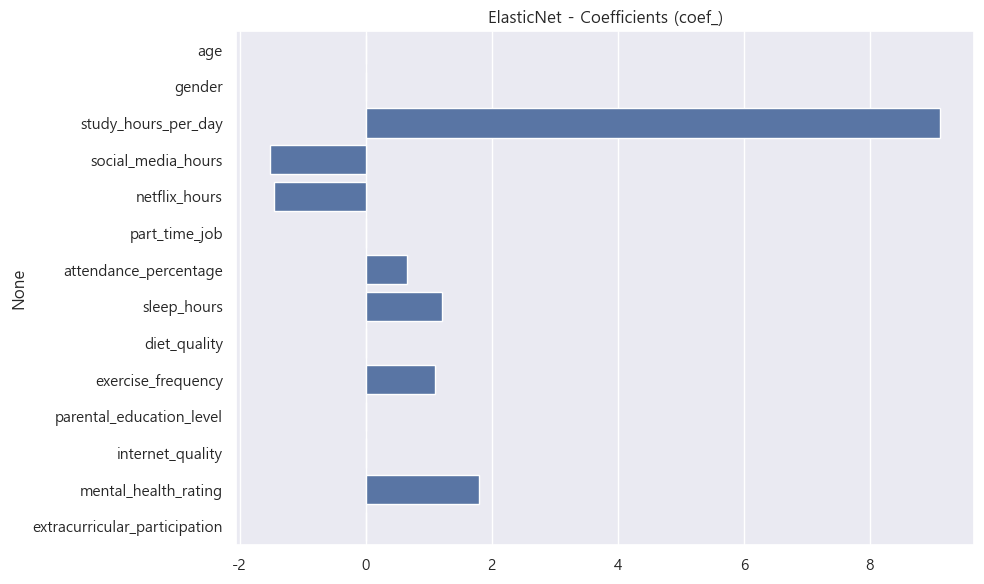

 6.5722  XGBRegressor   


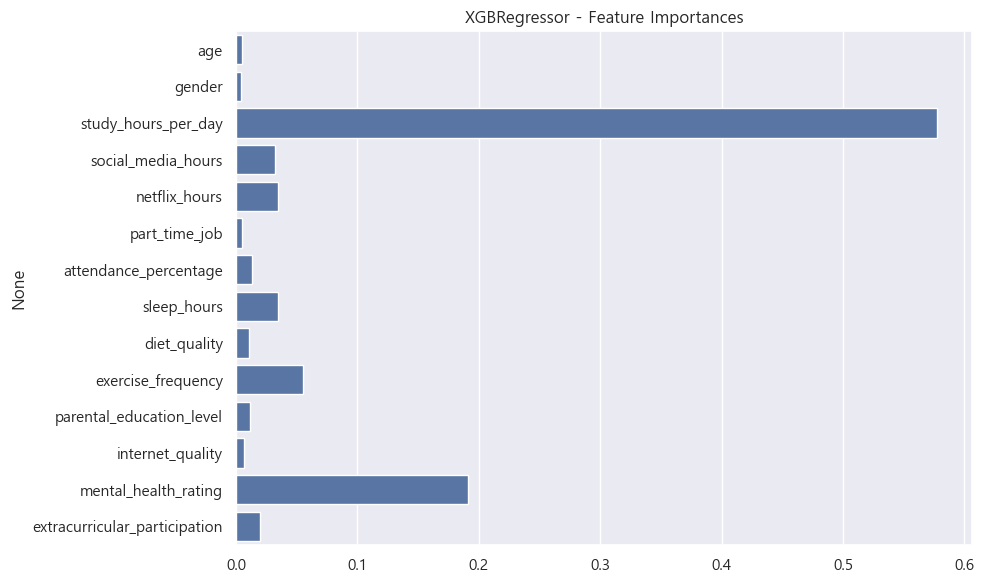

 6.3132  LGBMRegressor   


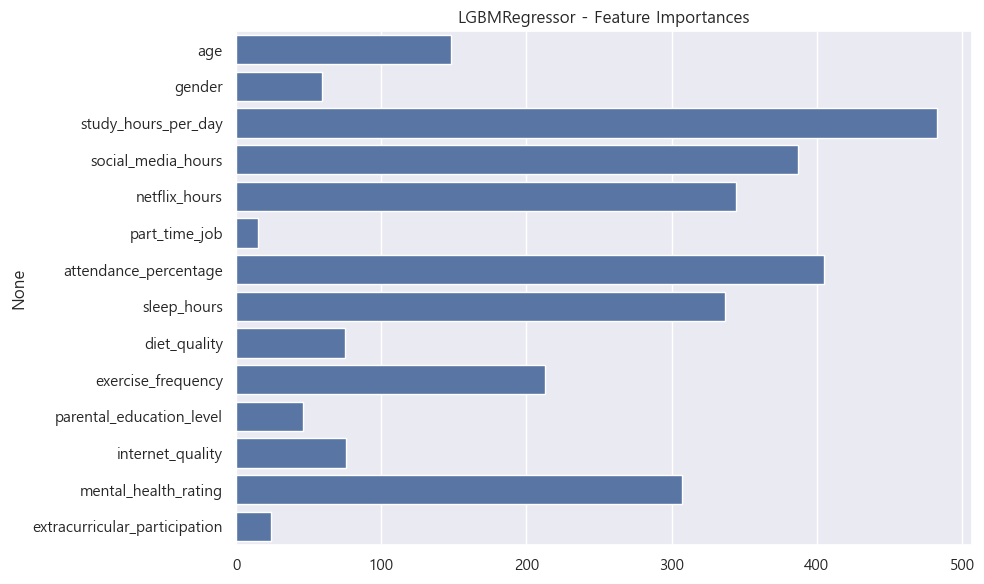

In [28]:
for model in model_list:
    model.fit(X80_final, y80)
    pred = model.predict(X20_final)
    mean_score = root_mean_squared_error(y20, pred)
    print( f" {mean_score:.4f}  {model.__class__.__name__}   " )
    feature_names = X80_final.columns
    # 2. 모델별 피처 중요도(또는 계수) 추출
    if hasattr(model, 'coef_'):
        # 선형 모델 (Ridge, Lasso, ElasticNet)
        importances = model.coef_
        title = f"{model.__class__.__name__} - Coefficients (coef_)"
        
    elif hasattr(model, 'feature_importances_'):
        # 트리 기반 모델 (DecisionTree, RandomForest, XGB, LGBM)
        importances = model.feature_importances_
        title = f"{model.__class__.__name__} - Feature Importances"
        
    else:
        # SVR(커널=rbf) 등은 해당 속성이 없음
        print(f"--- {model.__class__.__name__}는 coef_ / feature_importances_ 속성을 제공하지 않습니다. ---")
        continue # 다음 모델로 넘어감

    # 3. 바 차트(Bar chart) 그리기
    plt.figure(figsize=(10, 6)) # 매번 새 도화지를 만듦
    sns.barplot(x=importances, y=feature_names)
    plt.title(title)
    plt.tight_layout()
    plt.show() # 각 차트를 바로 보여줌

# 파생피쳐

In [29]:
df.head()

,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,23,0,0.0,1.2,1.1,0,85.0,8.0,0,6,2,0,8,1,56.2
1,20,0,6.9,2.8,2.3,0,97.3,4.6,1,6,1,0,8,0,100.0
2,21,1,1.4,3.1,1.3,0,94.8,8.0,2,1,1,2,1,0,34.3
3,23,0,1.0,3.9,1.0,0,71.0,9.2,2,4,2,1,1,1,26.8
4,19,0,5.0,4.4,0.5,0,90.9,4.9,0,3,2,1,1,0,66.4


In [30]:
# 총 휴식시간
df['total_rest_hours'] = df['social_media_hours'] + df['netflix_hours']

In [31]:
# 휴식 대비 공부 비율
df['rest_study_ratio'] = df['total_rest_hours'] / df['study_hours_per_day']
df['rest_study_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['rest_study_ratio'].fillna(0, inplace=True)

In [32]:
# 수면 대비 공부 효율
df['study_sleep_ratio'] = df['study_hours_per_day'] / df['sleep_hours']

In [33]:
df.head()

,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score,total_rest_hours,rest_study_ratio,study_sleep_ratio
0,23,0,0.0,1.2,1.1,0,85.0,8.0,0,6,2,0,8,1,56.2,2.3,0.000000,0.000000
1,20,0,6.9,2.8,2.3,0,97.3,4.6,1,6,1,0,8,0,100.0,5.1,0.739130,1.500000
2,21,1,1.4,3.1,1.3,0,94.8,8.0,2,1,1,2,1,0,34.3,4.4,3.142857,0.175000
3,23,0,1.0,3.9,1.0,0,71.0,9.2,2,4,2,1,1,1,26.8,4.9,4.900000,0.108696
4,19,0,5.0,4.4,0.5,0,90.9,4.9,0,3,2,1,1,0,66.4,4.9,0.980000,1.020408


수면 대비 공부 효율과 공부시간 다중공선

<Axes: >

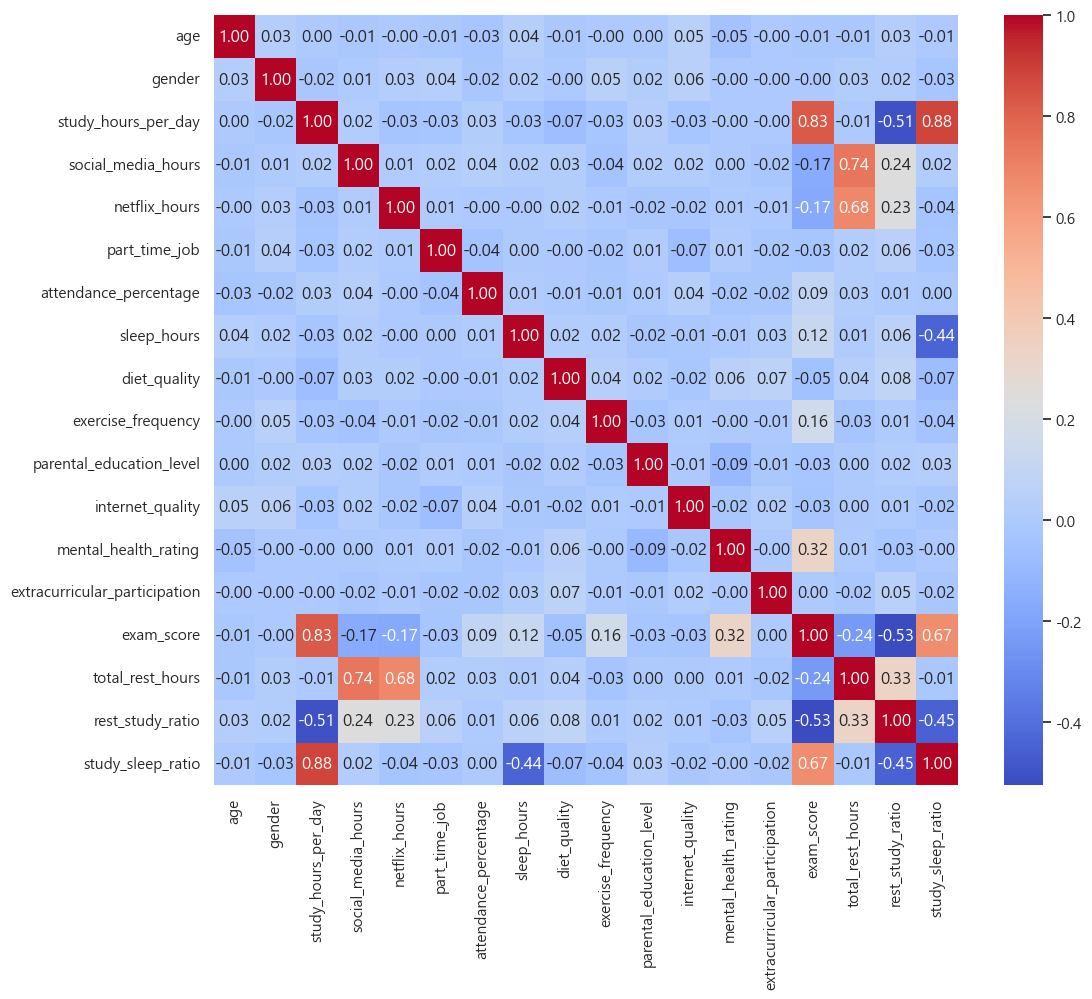

In [34]:
corr = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')

In [35]:
df = df.drop('study_sleep_ratio', axis = 1)

In [36]:
X = df.drop('exam_score', axis=1)
y = df['exam_score']

num_col = [col for col in X.columns if col not in cat_col]

X80, X20, y80, y20 = train_test_split(X, y, test_size=0.2, random_state=4444)



# X80, X20, y80, y20 = train_test_split(X, y, test_size=0.2, random_state=4444)
scaler = StandardScaler()

X80_scal = pd.DataFrame(
    scaler.fit_transform(X80[num_col]),
    columns=num_col,  # 원래 컬럼명 복원
    index=X80.index       # 원래 인덱스 복원
)

X20_scal = pd.DataFrame(
    scaler.transform(X20[num_col]),
    columns=num_col,  # 원래 컬럼명 복원
    index=X20.index       # 원래 인덱스 복원
)

# 4️⃣ 범주형 컬럼과 합치기
X80_final = pd.concat([X80_scal, X80[cat_col]], axis=1)
X20_final = pd.concat([X20_scal, X20[cat_col]], axis=1)

# 5️⃣ 컬럼 순서를 원본 X와 동일하게 맞추기
X80_final = X80_final[X.columns]
X20_final = X20_final[X.columns]

In [37]:
best_model = None
best_score = float('inf')

for model in model_list:
    model.fit(X80_final, y80)
    pred = model.predict(X20_final)
    mean_score = root_mean_squared_error(y20, pred)
    print( f" {mean_score:.4f}  {model.__class__.__name__}   " )
     # 성능이 가장 좋은 모델 저장
    if mean_score < best_score:
        best_score = mean_score
        best_model = model

print(f"\nBest model: {best_model.__class__.__name__} ({best_score:.4f})")

 9.6720  DecisionTreeRegressor   
 6.4746  RandomForestRegressor   
 7.8858  SVR   
 5.6086  Ridge   
 5.9371  Lasso   
 7.3823  ElasticNet   
 6.6285  XGBRegressor   
 6.0665  LGBMRegressor   

Best model: Ridge (5.6086)


| 전처리 방식              | DecisionTree | RandomForest | SVR        | Ridge      | Lasso      | ElasticNet | XGB        | LGBM       |
| :------------------ | :----------- | :----------- | :--------- | :--------- | :--------- | :--------- | :--------- | :--------- |
| **1차 점수 (원본)**      | 9.7866       | 6.5577       | 16.0220    | 5.6430     | 5.8281     | 6.4347     | 6.6833     | 6.4272     |
| **원-핫 인코딩**         | 11.5724      | 7.5368       | 16.2280    | 5.7369     | 7.9941     | 8.4535     | 7.4083     | 6.6011     |
| **스케일링**            | 9.6897       | 6.5456       | 8.3918     | 5.6422     | 6.0228     | 7.6309     | 6.6833     | 6.4029     |
| **로그 & 스케일링**       | 9.8578       | 6.5583       | 9.0187     | 6.0900     | 6.5964     | 8.2326     | 6.6833     | 6.4306     |
| **파생 피처 2개 + 스케일링** | 9.6720  | 6.4746  | 7.8858 | **5.6086** | 5.9371 | 7.3823 | 6.6285 | 6.0665 |

## shap

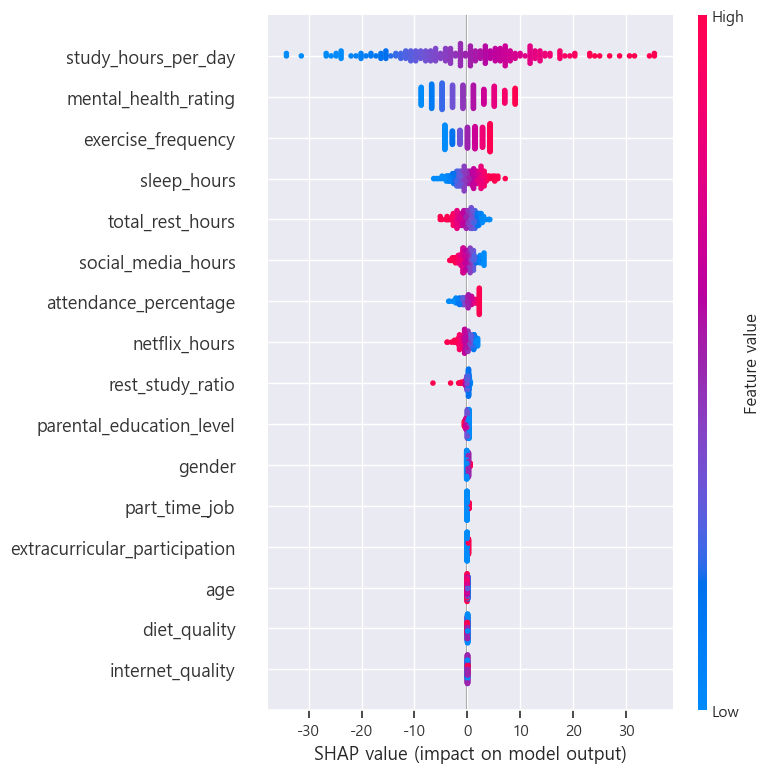

In [38]:
explainer = shap.Explainer(best_model, X80_final)
shap_values = explainer(X20_final)
shap.summary_plot(shap_values, X20_final)            

# GridSearchCV

In [39]:
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd

# 모델별 하이퍼파라미터 후보
param_grid = {
    'DecisionTreeRegressor': {'max_depth':[None,5,10], 'min_samples_split':[2,5,10]},
    'RandomForestRegressor': {'n_estimators':[100,200], 'max_depth':[None,5,10]},
    'SVR': {'C':[0.1,1,10], 'gamma':['scale','auto'], 'kernel':['rbf','linear']},
    'Ridge': {'alpha':[0.1,1.0,10.0]},
    'Lasso': {'alpha':[0.01,0.1,1.0]},
    'ElasticNet': {'alpha':[0.01,0.1,1.0], 'l1_ratio':[0.2,0.5,0.8]},
    'XGBRegressor': {'n_estimators':[100,200], 'max_depth':[3,5,7], 'learning_rate':[0.01,0.1]},
    'LGBMRegressor': {'n_estimators':[100,200], 'max_depth':[-1,5,10], 'learning_rate':[0.01,0.1]}
}

# (X80_final이 컬럼명을 가진 DataFrame이라고 가정)
try:
    feature_names = X80_final.columns
except AttributeError:
    print("오류: X80_final에 .columns 속성이 없습니다. X80_final이 DataFrame인지 확인하세요.")
    feature_names = None  # 임시 처리

results = []                    # ✅ 루프 밖에서 선언
coef_or_importance = {}         # ✅ 루프 밖에서 선언

for model in model_list:
    model_name = model.__class__.__name__
    print(f"\n--- {model_name} 튜닝 시작 ---")
    
    # 1) GridSearchCV 실행 (refit=True가 default)
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid[model_name],
        scoring='neg_root_mean_squared_error',
        cv=5,
        n_jobs=-1,
        refit=True,
    )
    grid.fit(X80_final, y80)
    
    # 2) 최적 모델로 예측 및 평가
    best_model = grid.best_estimator_  # 이미 학습 완료
    pred = best_model.predict(X20_final)
    mean_score = root_mean_squared_error(y20, pred)
    print(f"Best Params: {grid.best_params_}")
    print(f"Test RMSE: {mean_score:.4f}")

    # 3) ✅ 'best_model'의 계수/중요도 추출 (재학습 X)
    df_explain = None

    # (a) 계수 기반: Lasso/Ridge/ElasticNet 또는 SVR(linear)
    if hasattr(best_model, "coef_"):
        # SVR인 경우 kernel 확인
        if model_name == "SVR" and getattr(best_model, "kernel", None) != "linear":
            pass  # rbf 등은 coef_ 없음
        else:
            coef_vals = np.asarray(best_model.coef_)
            if coef_vals.ndim == 1:
                # feature_names가 없으면 임시 이름 생성
                feats = feature_names if feature_names is not None else [f"f{i}" for i in range(len(coef_vals))]
                df_explain = pd.DataFrame({"feature": feats, "coef": coef_vals}).sort_values("coef", ascending=False)

    # (b) 트리/부스팅: feature_importances_
    elif hasattr(best_model, "feature_importances_"):
        imp_vals = np.asarray(best_model.feature_importances_)
        feats = feature_names if (feature_names is not None and len(feature_names) == len(imp_vals)) \
                else [f"f{i}" for i in range(len(imp_vals))]
        df_explain = pd.DataFrame({"feature": feats, "importance": imp_vals}).sort_values("importance", ascending=False)

    if df_explain is not None:
        coef_or_importance[model_name] = df_explain

    # 4) 성능 요약 저장
    results.append({
        "model": model_name,
        "best_params": grid.best_params_,
        "test_rmse": float(mean_score)
    })


--- DecisionTreeRegressor 튜닝 시작 ---
Best Params: {'max_depth': 5, 'min_samples_split': 2}
Test RMSE: 8.7090

--- RandomForestRegressor 튜닝 시작 ---
Best Params: {'max_depth': 10, 'n_estimators': 100}
Test RMSE: 6.4655

--- SVR 튜닝 시작 ---
Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Test RMSE: 5.7288

--- Ridge 튜닝 시작 ---
Best Params: {'alpha': 1.0}
Test RMSE: 5.6086

--- Lasso 튜닝 시작 ---
Best Params: {'alpha': 0.1}
Test RMSE: 5.5930

--- ElasticNet 튜닝 시작 ---
Best Params: {'alpha': 0.01, 'l1_ratio': 0.8}
Test RMSE: 5.6038

--- XGBRegressor 튜닝 시작 ---
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Test RMSE: 5.7758

--- LGBMRegressor 튜닝 시작 ---
Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Test RMSE: 5.9523


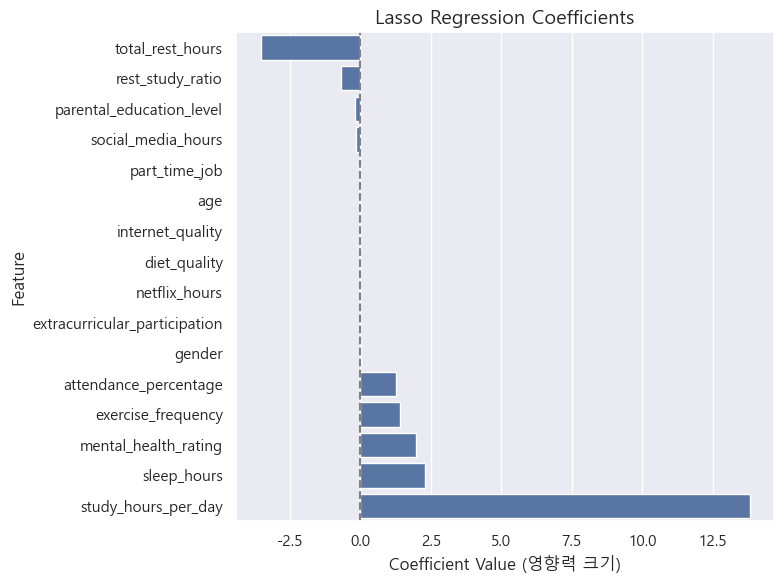

In [40]:
# Lasso 계수 데이터 불러오기
lasso_coef = coef_or_importance.get("Lasso")

if lasso_coef is not None:
    plt.figure(figsize=(8, 6))
    sns.barplot(
        data=lasso_coef.sort_values("coef", ascending=True),  # 값 오름차순 → 아래로 갈수록 음수
        y="feature",
        x="coef",
    )
    plt.title("Lasso Regression Coefficients", fontsize=14)
    plt.xlabel("Coefficient Value (영향력 크기)", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.axvline(0, color='gray', linestyle='--')  # 0 기준선
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Lasso 계수 정보(coef_or_importance['Lasso'])가 없습니다.")

<pre>
Lasso(α=0.1) 는 불필요한 피처의 잡음(노이즈)을 줄이면서,
핵심 피처만 남겨 과적합을 방지하고 일반화 성능 높아짐

| 전처리 방식 / 모델                  | DecisionTree | RandomForest | SVR        | Ridge      | Lasso      | ElasticNet | XGB        | LGBM       |
| :--------------------------- | :----------- | :----------- | :--------- | :--------- | :--------- | :--------- | :--------- | :--------- |
| **1차 점수 (원본)**               | 9.7866       | 6.5577       | 16.0220    | 5.6430     | 5.8281     | 6.4347     | 6.6833     | 6.4272     |
| **원-핫 인코딩**                  | 11.5724      | 7.5368       | 16.2280    | 5.7369     | 7.9941     | 8.4535     | 7.4083     | 6.6011     |
| **스케일링**                     | 9.6897       | 6.5456       | 8.3918     | 5.6422     | 6.0228     | 7.6309     | 6.6833     | 6.4029     |
| **로그 & 스케일링**                | 9.8578       | 6.5583       | 9.0187     | 6.0900     | 6.5964     | 8.2326     | 6.6833     | 6.4306     |
| **파생 피처 2개 + 스케일링**          | 9.6720       | 6.4746       | 7.8858     | **5.6086** | 5.9371     | 7.3823     | 6.6285     | 6.0665     |
| **튜닝 후 CV (Best Params 적용)** | 8.7090   | 6.4655   | 5.7288 | 5.6086 | **5.5930** | 5.6038 | 5.7758 | 5.9523 |



| 순위       | 모델                        | RMSE | 최적 하이퍼파라미터 (Best Params)                                      |
| :------- | :------------------------ | :------------------ | :------------------------------------------------------------ |
| 🥇 **1** | **Lasso**                 | **5.5930**          | `{'alpha': 0.1}`                                              |
| 🥈 **2** | **ElasticNet**            | **5.6038**          | `{'alpha': 0.01, 'l1_ratio': 0.8}`                            |
| 🥉 **3** | **Ridge**                 | **5.6086**          | `{'alpha': 1.0}`                                              |
| 4        | **SVR**                   | 5.7288              | `{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}`              |
| 5        | **XGBRegressor**          | 5.7758              | `{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}` |
| 6        | **LGBMRegressor**         | 5.9523              | `{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}` |
| 7        | **RandomForestRegressor** | 6.4655              | `{'max_depth': 10, 'n_estimators': 100}`                      |
| 8        | **DecisionTreeRegressor** | 8.7090              | `{'max_depth': 5, 'min_samples_split': 2}`                    |


# 앙상블

## Voting

In [41]:
# ✅ Best Params 그대로 사용
ridge = Ridge(alpha=1.0, random_state=42)
svr   = SVR(C=1, gamma='scale', kernel='linear')
lgbm  = LGBMRegressor(learning_rate=0.1, max_depth=5, n_estimators=100, verbosity=-1, random_state=42)

models = [ridge, svr, lgbm]

# 학습 & 예측
preds = []
for m in models:
    m.fit(X80_final, y80)
    preds.append(m.predict(X20_final))

# 1) 단순 평균 보팅
pred_avg = np.mean(np.column_stack(preds), axis=1)
rmse_avg = root_mean_squared_error(y20, pred_avg)

# 2) (선택) 가중 평균 보팅 — 튜닝 없이, CV RMSE 역수 가중치만 사용
rmse_ref = {
    "ridge": 5.6086,
    "svr":   5.7288,
    "lgbm":  5.9523,
}
w = np.array([1/rmse_ref["ridge"], 1/rmse_ref["svr"], 1/rmse_ref["lgbm"]], dtype=float)
w = w / w.sum()

pred_w = w[0]*preds[0] + w[1]*preds[1] + w[2]*preds[2]
rmse_w = root_mean_squared_error(y20, pred_w)
print(f"[Voting] RMSE: {rmse_w:.4f}")


[Voting] RMSE: 5.5384


| 모델              | 선택 이유                              |
| --------------- | ---------------------------------- |
| **Ridge**       | 선형 모델로 과적합을 방지하며 **전체적 안정성** 제공    |
| **SVR(linear)** | 스케일링 데이터에서 **거리 기반의 세밀한 패턴** 포착    |
| **LGBM**        | 트리 기반 부스팅으로 **비선형 관계와 변수 상호작용** 반영 |


## Stacking

In [44]:
# ✅ Best Params 그대로 사용
ridge = Ridge(alpha=1.0, random_state=42)
lasso = Lasso(alpha=0.1, random_state=42)
svr   = SVR(C=1, gamma='scale', kernel='linear')
lgbm  = LGBMRegressor(learning_rate=0.1, max_depth=5, n_estimators=100, verbosity=-1, random_state=42)

base_models = [
    ("ridge", ridge),
    ("lasso", lasso),
    ("svr",   svr),
    ("lgbm",  lgbm),
]

meta_model = Ridge(alpha=1.0, random_state=42)  # 안정적이고 과적합에 강함

stack = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

stack.fit(X80_final, y80)
pred_stack = stack.predict(X20_final)
rmse_stack = root_mean_squared_error(y20, pred_stack)
print(f"[Stacking] RMSE: {rmse_stack:.4f}")


[Stacking] RMSE: 5.5451


| 구분                   | 모델              | 선택 이유                             |
| -------------------- | --------------- | --------------------------------- |
| **Base Layer (1단계)** | **Ridge**       | 전체적 선형 경향을 안정적으로 학습, 과적합 방지       |
|                      | **Lasso**       | 불필요한 변수 제거(L1 규제)로 핵심 피처 강조       |
|                      | **SVR(linear)** | 스케일링 데이터에서 거리 기반 경향을 세밀하게 보정      |
|                      | **LGBM**        | 트리 기반 부스팅으로 비선형 관계 및 변수 상호작용 포착   |
| **Meta Layer (2단계)** | **Ridge**       | 각 모델의 예측값을 종합하면서 과적합을 억제하고 안정성 확보 |

<pre>
본 스태킹 구성은 Ridge, Lasso, SVR, LGBM 등
복잡도가 과도하지 않은 모델들로 구성되어 있으며,
각 모델이 데이터의 다른 특성을 보완적으로 학습하므로
전체적으로 과적합 위험이 낮고 안정적인 예측 성능을 보였다.

| 전처리 방식 / 모델                  | DecisionTree | RandomForest | SVR     | Ridge      | Lasso      | ElasticNet | XGB    | LGBM   | **Voting** | **Stacking** |
| :--------------------------- | :----------- | :----------- | :------ | :--------- | :--------- | :--------- | :----- | :----- | :--------- | :----------- |
| **1차 점수 (원본)**               | 9.7866       | 6.5577       | 16.0220 | 5.6430     | 5.8281     | 6.4347     | 6.6833 | 6.4272 | —          | —            |
| **원-핫 인코딩**                  | 11.5724      | 7.5368       | 16.2280 | 5.7369     | 7.9941     | 8.4535     | 7.4083 | 6.6011 | —          | —            |
| **스케일링**                     | 9.6897       | 6.5456       | 8.3918  | 5.6422     | 6.0228     | 7.6309     | 6.6833 | 6.4029 | —          | —            |
| **로그 & 스케일링**                | 9.8578       | 6.5583       | 9.0187  | 6.0900     | 6.5964     | 8.2326     | 6.6833 | 6.4306 | —          | —            |
| **파생 피처 2개 + 스케일링**          | 9.6720       | 6.4746       | 7.8858  | **5.6086** | 5.9371     | 7.3823     | 6.6285 | 6.0665 | —          | —            |
| **튜닝 후 CV (Best Params 적용)** | 8.7090       | 6.4655       | 5.7288  | 5.6086     | **5.5930** | 5.6038     | 5.7758 | 5.9523 | —          | —            |
| **앙상블 (Voting / Stacking)**  | —            | —            | —       | —          | —          | —          | —      | —      | **5.5384** | 5.5451   |

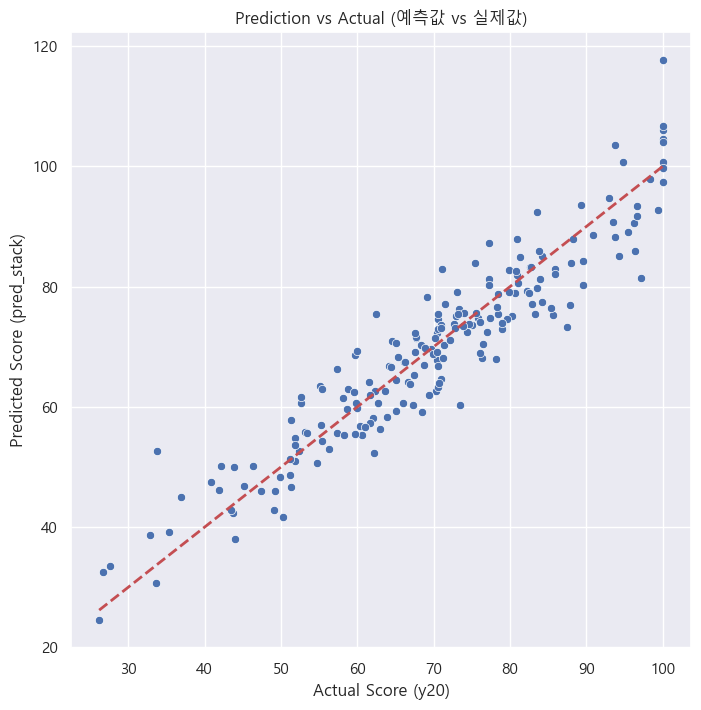

In [45]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y20, y=pred_stack)
plt.title('Prediction vs Actual (예측값 vs 실제값)')
plt.xlabel('Actual Score (y20)')
plt.ylabel('Predicted Score (pred_stack)')

# 45도 직선 그리기 (참고용)
plt.plot([y20.min(), y20.max()], [y20.min(), y20.max()], 'r--', lw=2) 
plt.show()